
# CIFAR-10 CNN (4 Conv Layers) — ReLU vs Tanh  
**Early stop at 25% train error + Per-epoch timing & combined figure**



## Setup & Imports


In [3]:

# If TensorFlow is not installed in your environment, uncomment the next line:
# !pip install -q tensorflow

import os, random, sys, time, math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.20.0
GPUs: []


- According to the assignment I should train the network until I get <= 25% training error. Once the training error
reaches 25% I stop training.
- Meaning Training error=1−Training accuracy then Training error=1−0.75 = 0.25
- So I will initialize a variable TARGET_TRAIN_ACCURACY = 0.75%

In [ ]:

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

BATCH_SIZE = 128
MAX_EPOCHS = 300
TARGET_TRAIN_ACCURACY = 0.75



## Load CIFAR-10 & Preprocess


In [5]:

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.squeeze().astype("int32")
y_test  = y_test.squeeze().astype("int32")
x_train = x_train.astype("float32")/255.0
x_test  = x_test.astype("float32")/255.0

print("Train:", x_train.shape, y_train.shape, " Test:", x_test.shape, y_test.shape)


Train: (50000, 32, 32, 3) (50000,)  Test: (10000, 32, 32, 3) (10000,)


## Exploration of the dataset

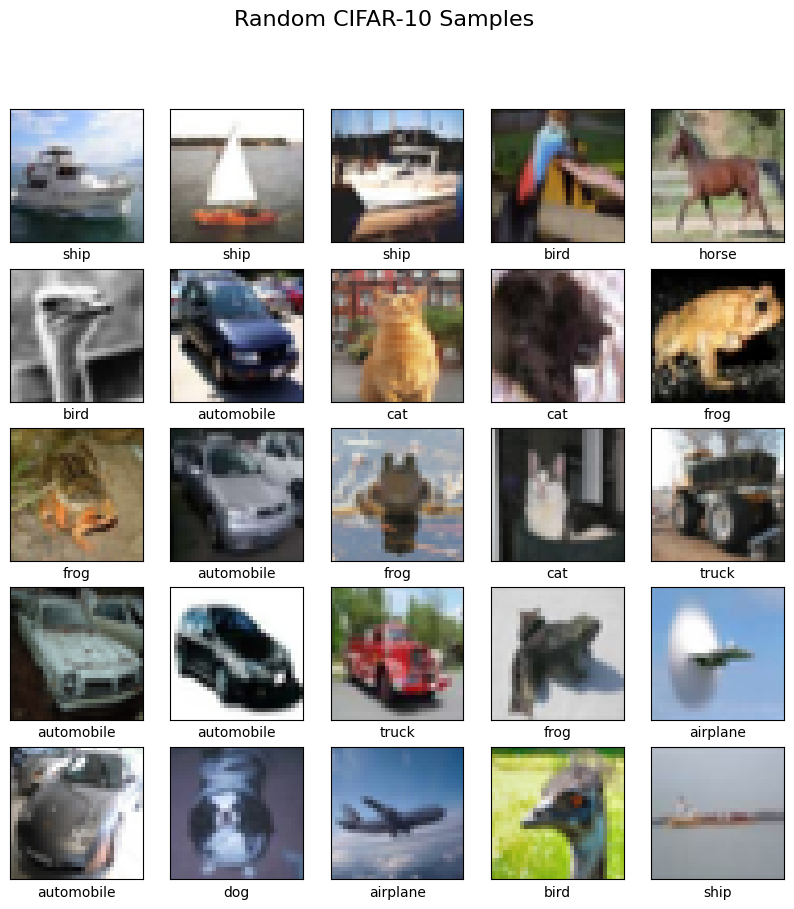

In [6]:
# CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Plot some random training samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(25):  # show 25 random images
    idx = np.random.randint(0, len(x_train))  # pick random index
    plt.subplot(5, 5, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx])
    plt.xlabel(class_names[y_train[idx]])
plt.suptitle("Random CIFAR-10 Samples", fontsize=16)
plt.show()



## Datasets & Augmentation


In [7]:

AUTOTUNE = tf.data.AUTOTUNE

# Fixed validation split (10% of training)
val_fraction = 0.1
val_size = int(len(x_train) * val_fraction)
x_val, y_val = x_train[:val_size], y_train[:val_size]
x_train_sub, y_train_sub = x_train[val_size:], y_train[val_size:]
print("val:",x_val,y_val )
train_ds = (tf.data.Dataset.from_tensor_slices((x_train_sub, y_train_sub))
            .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
            .batch(BATCH_SIZE).prefetch(AUTOTUNE))
val_ds   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

do_augment = True
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")


val: [[[[0.23137255 0.24313726 0.24705882]
   [0.16862746 0.18039216 0.1764706 ]
   [0.19607843 0.1882353  0.16862746]
   ...
   [0.61960787 0.5176471  0.42352942]
   [0.59607846 0.49019608 0.4       ]
   [0.5803922  0.4862745  0.40392157]]

  [[0.0627451  0.07843138 0.07843138]
   [0.         0.         0.        ]
   [0.07058824 0.03137255 0.        ]
   ...
   [0.48235294 0.34509805 0.21568628]
   [0.46666667 0.3254902  0.19607843]
   [0.47843137 0.34117648 0.22352941]]

  [[0.09803922 0.09411765 0.08235294]
   [0.0627451  0.02745098 0.        ]
   [0.19215687 0.10588235 0.03137255]
   ...
   [0.4627451  0.32941177 0.19607843]
   [0.47058824 0.32941177 0.19607843]
   [0.42745098 0.28627452 0.16470589]]

  ...

  [[0.8156863  0.6666667  0.3764706 ]
   [0.7882353  0.6        0.13333334]
   [0.7764706  0.6313726  0.10196079]
   ...
   [0.627451   0.52156866 0.27450982]
   [0.21960784 0.12156863 0.02745098]
   [0.20784314 0.13333334 0.07843138]]

  [[0.7058824  0.54509807 0.3764706 ]
  


## Model Builder (Four Conv Layers)


In [ ]:

def build_cnn(activation: str = "relu", input_shape=(32, 32, 3), n_classes: int = 10) -> keras.Model:
    inputs = keras.Input(shape=input_shape, name="images")
    x = inputs
    if do_augment:
        x = data_augmentation(x)

    # Block A (2 conv layers) -> Pool -> Dropout
    x = layers.Conv2D(32, 3, padding="same", activation=activation)(x)
    x = layers.Conv2D(32, 3, padding="same", activation=activation)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block B (2 conv layers) -> Pool -> Dropout
    x = layers.Conv2D(64, 3, padding="same", activation=activation)(x)
    x = layers.Conv2D(64, 3, padding="same", activation=activation)(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Classifier head
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=activation)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name=f"cnn_4conv_{activation}")

_ = build_cnn("relu").summary()


Model: "cnn_4conv_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ images (InputLayer)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,116,970 (4.26 MB)

 Trainable params: 1,116,970 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

### What this cell does
- **StopOnTrainingAccuracy**: Stops training early once training accuracy ≥ 0.75 (train error ≤ 25%).  
- Because saying “stop when training error ≤ 25%” is the same as saying “stop when training accuracy ≥ 75%”.
- **EpochTimeHistory**: Records the time taken for each epoch.


In [9]:
class StopOnTrainingAccuracy(keras.callbacks.Callback):
    def __init__(self, target_accuracy: float = 0.75):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get("accuracy") or logs.get("sparse_categorical_accuracy")
        if train_acc is not None and train_acc >= self.target_accuracy:
            print(f"\nReached training accuracy {train_acc:.3f} ≥ {self.target_accuracy:.2f}. Stopping.")
            self.model.stop_training = True

class EpochTimeHistory(keras.callbacks.Callback):
    # Record time (seconds) for each epoch in self.epoch_times
    def on_train_begin(self, logs=None):
        self._epoch_start = None
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self._epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self._epoch_start)



## Compile Helper


In [10]:

def compile_model(model: keras.Model, lr: float = 1e-3):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model



## Train Utility


In [11]:

def train_model(activation: str):
    model = build_cnn(activation=activation)
    compile_model(model)
    stop_cb = StopOnTrainingAccuracy(target_accuracy=TARGET_TRAIN_ACCURACY)
    time_cb = EpochTimeHistory()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        callbacks=[stop_cb, time_cb],
        verbose=2
    )
    return model, history, time_cb.epoch_times



## Run: ReLU vs Tanh


In [14]:

histories = {}
epoch_times = {}

print("\n Training with ReLU activation")
model_relu, hist_relu, times_relu = train_model("relu")
histories["relu"] = hist_relu.history
epoch_times["relu"] = times_relu
print("ReLU epochs:", len(histories["relu"]["accuracy"]))



 Training with ReLU activation
Epoch 1/100
352/352 - 22s - 63ms/step - accuracy: 0.3568 - loss: 1.7626 - val_accuracy: 0.4824 - val_loss: 1.4237
Epoch 2/100
352/352 - 19s - 55ms/step - accuracy: 0.5007 - loss: 1.3965 - val_accuracy: 0.5592 - val_loss: 1.2320
Epoch 3/100
352/352 - 49s - 140ms/step - accuracy: 0.5529 - loss: 1.2498 - val_accuracy: 0.5998 - val_loss: 1.1213
Epoch 4/100
352/352 - 36s - 103ms/step - accuracy: 0.5884 - loss: 1.1622 - val_accuracy: 0.6308 - val_loss: 1.0511
Epoch 5/100
352/352 - 62s - 177ms/step - accuracy: 0.6156 - loss: 1.0988 - val_accuracy: 0.6738 - val_loss: 0.9195
Epoch 6/100
352/352 - 52s - 147ms/step - accuracy: 0.6306 - loss: 1.0490 - val_accuracy: 0.6814 - val_loss: 0.8974
Epoch 7/100
352/352 - 28s - 81ms/step - accuracy: 0.6463 - loss: 1.0125 - val_accuracy: 0.6738 - val_loss: 0.9179
Epoch 8/100
352/352 - 70s - 198ms/step - accuracy: 0.6591 - loss: 0.9727 - val_accuracy: 0.6898 - val_loss: 0.8976
Epoch 9/100
352/352 - 57s - 162ms/step - accuracy: 

In [15]:
print("\n Training with Tanh activation")
model_tanh, hist_tanh, times_tanh = train_model("tanh")
histories["tanh"] = hist_tanh.history
epoch_times["tanh"] = times_tanh

print("Tanh epochs:", len(histories["tanh"]["accuracy"]))


 Training with Tanh activation
Epoch 1/100
352/352 - 30s - 85ms/step - accuracy: 0.4221 - loss: 1.6181 - val_accuracy: 0.5414 - val_loss: 1.3429
Epoch 2/100
352/352 - 24s - 67ms/step - accuracy: 0.5365 - loss: 1.3301 - val_accuracy: 0.5950 - val_loss: 1.1869
Epoch 3/100
352/352 - 19s - 55ms/step - accuracy: 0.5717 - loss: 1.2324 - val_accuracy: 0.5724 - val_loss: 1.2888
Epoch 4/100
352/352 - 18s - 52ms/step - accuracy: 0.5846 - loss: 1.1945 - val_accuracy: 0.6090 - val_loss: 1.1659
Epoch 5/100
352/352 - 18s - 52ms/step - accuracy: 0.5985 - loss: 1.1503 - val_accuracy: 0.5636 - val_loss: 1.3395
Epoch 6/100
352/352 - 18s - 52ms/step - accuracy: 0.6049 - loss: 1.1324 - val_accuracy: 0.6036 - val_loss: 1.1513
Epoch 7/100
352/352 - 19s - 53ms/step - accuracy: 0.6166 - loss: 1.0940 - val_accuracy: 0.6368 - val_loss: 1.0707
Epoch 8/100
352/352 - 18s - 52ms/step - accuracy: 0.6229 - loss: 1.0806 - val_accuracy: 0.6536 - val_loss: 1.0006
Epoch 9/100
352/352 - 18s - 52ms/step - accuracy: 0.6287


## Single Figure: Training Error & Time per Epoch
- Left y-axis: Training error (1 - accuracy)
- Right y-axis: Seconds per epoch
- X-axis: Epoch number


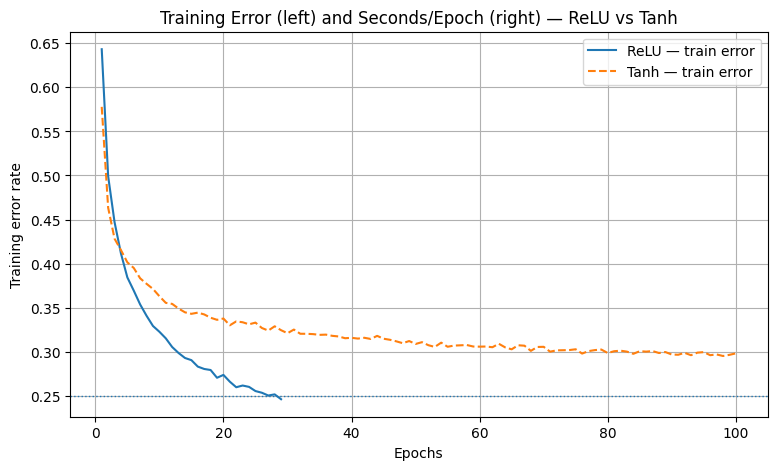

In [ ]:

# Compute training error arrays
relu_train_err = 1 - np.array(histories["relu"]["accuracy"], dtype=float)
tanh_train_err = 1 - np.array(histories["tanh"]["accuracy"], dtype=float)

epochs_relu = np.arange(1, len(relu_train_err)+1)
epochs_tanh = np.arange(1, len(tanh_train_err)+1)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: training error
line1, = ax1.plot(epochs_relu, relu_train_err, label="ReLU — train error")
line2, = ax1.plot(epochs_tanh, tanh_train_err, linestyle="--", label="Tanh — train error")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training error rate")
ax1.grid(True)
ax1.axhline(0.25, linestyle=":", linewidth=1, label="Target error 0.25")


# Combine legends
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")
plt.title("Training Error (left) and Seconds/Epoch (right) — ReLU vs Tanh")
plt.show()


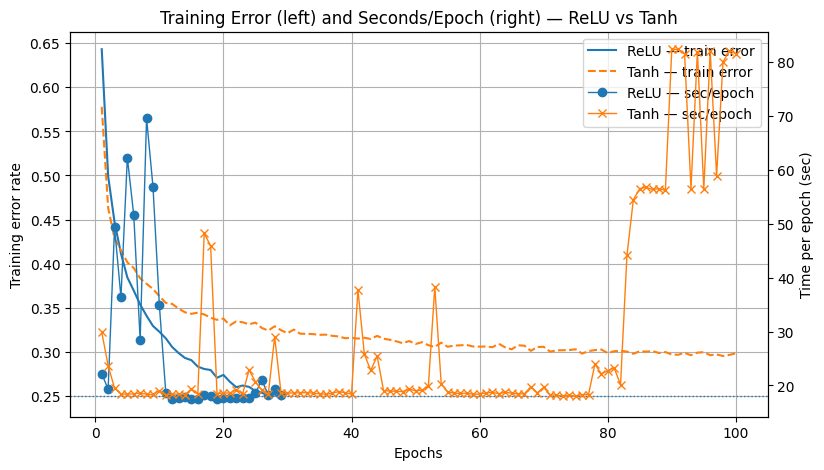

In [20]:

# Compute training error arrays
relu_train_err = 1 - np.array(histories["relu"]["accuracy"], dtype=float)
tanh_train_err = 1 - np.array(histories["tanh"]["accuracy"], dtype=float)

epochs_relu = np.arange(1, len(relu_train_err)+1)
epochs_tanh = np.arange(1, len(tanh_train_err)+1)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: training error
line1, = ax1.plot(epochs_relu, relu_train_err, label="ReLU — train error")
line2, = ax1.plot(epochs_tanh, tanh_train_err, linestyle="--", label="Tanh — train error")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training error rate")
ax1.grid(True)
ax1.axhline(0.25, linestyle=":", linewidth=1, label="Target error 0.25")

# Right axis: time per epoch
ax2 = ax1.twinx()
line3, = ax2.plot(np.arange(1, len(epoch_times["relu"])+1), epoch_times["relu"], marker="o", linewidth=1, label="ReLU — sec/epoch")
line4, = ax2.plot(np.arange(1, len(epoch_times["tanh"])+1), epoch_times["tanh"], marker="x", linewidth=1, label="Tanh — sec/epoch")
ax2.set_ylabel("Time per epoch (sec)")

# Combine legends
lines = [line1, line2, line3, line4]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="best")
plt.title("Training Error (left) and Seconds/Epoch (right) — ReLU vs Tanh")
plt.show()


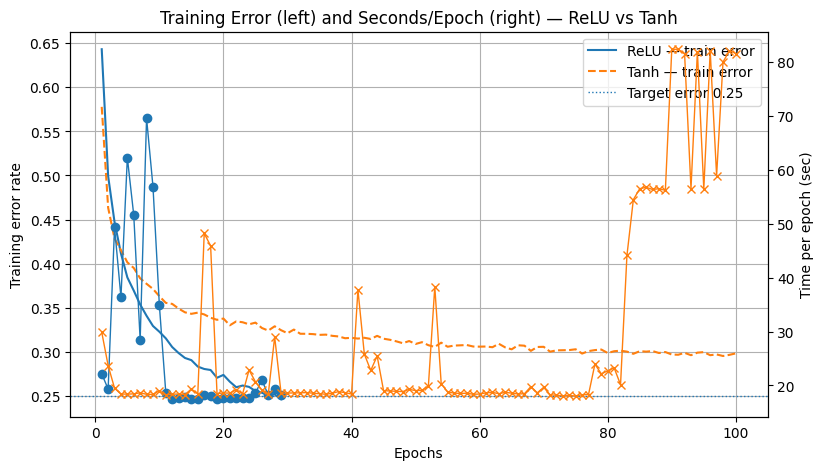

In [18]:
# Compute training error arrays
relu_train_err = 1 - np.array(histories["relu"]["accuracy"], dtype=float)
tanh_train_err = 1 - np.array(histories["tanh"]["accuracy"], dtype=float)
epochs_relu = np.arange(1, len(relu_train_err)+1)
epochs_tanh = np.arange(1, len(tanh_train_err)+1)

fig, ax1 = plt.subplots(figsize=(9, 5))

# Left axis: training error (label these so they appear in legend)
ax1.plot(epochs_relu, relu_train_err, label="ReLU — train error")
ax1.plot(epochs_tanh, tanh_train_err, linestyle="--", label="Tanh — train error")
ax1.axhline(0.25, linestyle=":", linewidth=1, label="Target error 0.25")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training error rate")
ax1.grid(True)

# Right axis: seconds/epoch (NO labels → they won't show in legend)
ax2 = ax1.twinx()
ax2.plot(np.arange(1, len(epoch_times["relu"])+1), epoch_times["relu"], marker="o", linewidth=1)
ax2.plot(np.arange(1, len(epoch_times["tanh"])+1), epoch_times["tanh"], marker="x", linewidth=1)
ax2.set_ylabel("Time per epoch (sec)")

# Clean legend: only error curves + target line
ax1.legend(loc="best")

plt.title("Training Error (left) and Seconds/Epoch (right) — ReLU vs Tanh")
plt.show()


- from the result we can say that ReLU converges much faster and reaches the 25% training error target, while Tanh fails to reach that threshold within 100 epochs.


## Evaluate on Test Set


In [ ]:

loss, acc_relu = model_relu.evaluate(test_ds, verbose=0)
loss, acc_tanh = model_tanh.evaluate(test_ds, verbose=0)
print({"relu_test_acc": float(acc_relu), "tanh_test_acc": float(acc_tanh)})


{'relu_test_acc': 0.7663000226020813, 'tanh_test_acc': 0.6983000040054321}
